Projeto: Análise de atrito de funcionários RH IBM.
Descrição: Projeto de ciência de dados para prever a saída (attrition) de funcionários, 
utilizando o dataset IBM HR Analytics. O objetivo principal é apoiar a área de 
Recursos Humanos (RH) na implementação de estratégias de retenção proativas.

Autor: Ivan Luís Duarte

LinkedIn: https://www.linkedin.com/in/ivanluisduarte/

GitHub: https://github.com/ivanluisduarte

Data de Criação: 2025-10-23

Licença: MIT

# Busca pelo melhor modelo e hiperparametros

## Importações

In [1]:
# facilita a análise de coeficientes
from src.auxiliares import fnc_dataframe_coeficientes

from src.config import (
    DADOS_LIMPOS,  # dados de entrada
    MODELO_FINAL,  # modelo final treinado
    N_JOBS,        # controla o número de núcleos processadores utilizados
    RANDOM_STATE,  # semente para replicar os resultados noutro momento
)
from src.graficos import (
    PALETTE_TEMPERATURA,  # paleta de cores para gráficos e tabelas
    plot_matrizes_confusao,  # facilita a plotagem de matrizes de confusão
)
from src.models import (
    fnc_extended_classification_report,  # facilita a análise de resultados
    fnc_grid_search_cv_classificador,  # facilita grid search no melhor modelo
    fnc_treinar_e_validar_modelo_classificacao,  # facilita treino e validação
)

import numpy as np
import pandas as pd

# codificação WOE - Weight of Evidence - para categorias nominais com muitas opções
from category_encoders.woe import WOEEncoder

# undersampling para balancear os dados de treino e validação
from imblearn.under_sampling import RandomUnderSampler

from joblib import dump  # para salvar o modelo final

from sklearn.compose import ColumnTransformer  # para preparar os dados

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (  # para normalizar os dados de entrada
    LabelEncoder,  # para codificação do target
    MinMaxScaler,  # para mudar a escala das colunas numéricas uniformes
    OrdinalEncoder,  # para codificação de categorias ordinais
    OneHotEncoder,  # para codificação de categoricas nominais com poucas opções
    PowerTransformer,  # para mudar a escala das colunas numéricas não uniformes
)

# classificador referência
from sklearn.dummy import DummyClassifier

# estudo linear
from sklearn.linear_model import LogisticRegression

## Funções auxiliares

In [2]:
# não precisava ser uma função, mas fica mais organizado assim.
# também não justifica um arquivo só para isso.
def fnc_get_colunas_ordenadas(
    colunas_ordenadas: list | tuple | np.ndarray | pd.Series
) -> list:
    '''
        Retorna as colunas em ordem de importância, removendo duplicatas

        Args:
            colunas_ordenadas: list | tuple | np.ndarray | pd.Series
        Returns:
            list: Lista de colunas em duplicidade na ordem de importancia

        Examples:
            >>> resultado = fnc_get_colunas_ordenadas(coefs.index)
            >>> print(resultado)
            ['salario', 'carga_horaria']
    '''

    # removendo duplicatas e mantendo ordem da lista
    return list(dict.fromkeys(
        [x.split('__')[1].split('_')[0] for x in colunas_ordenadas]
    ))

In [3]:
# não precisava ser uma função, mas fica mais organizado assim.
# também não justifica um arquivo só para isso.
def fnc_scale_pos_weight(y, flg_print=True, flg_return=False):
    """
    Calcula a proporção entre o número de instâncias da classe 0 e da classe 1.

    Args:
        y (array-like): Array com as classes das instâncias.
        flg_print (bool, optional): Se deve imprimir a proporção. 
            Por padrão é True.
        flg_return (bool, optional): Se deve retornar a proporção.
            Por padrão é False.

    Returns:
        float or None: A proporção entre o número de instâncias da classe 0 e da classe 1
        se flg_return for True. Caso contrário, retorna None.
    """
    if flg_print or flg_return:
        # Conta o número de instâncias para cada classe
        c0, c1 = np.bincount(y)
    else:
        return None

    # Calcula a proporção entre o número de instâncias da classe 0 e da classe 1
    scale_pos_weight = c0 / c1

    # Imprime a proporção
    if flg_print:
        print(f'{c0} / {c1} = {scale_pos_weight}')

    if flg_return:
        return scale_pos_weight

## Carregando dados

In [4]:
melhores_colunas = [
    'BusinessTravel',
    'DailyRate',
    'Department-JobRole',
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobSatisfaction',
    'MaritalStatus',
    'NumCompaniesWorked',
    'OverTime',
    'StockOptionLevel',
    'TotalWorkingYears',
    'WorkLifeBalance',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager'
]

# coluna target - alvo binário: Yes/No
coluna_alvo = 'Attrition'  # transformação label encoder

In [5]:
df = pd.read_parquet(
    path=DADOS_LIMPOS,
    columns=[coluna_alvo] + melhores_colunas
)

with pd.option_context('display.max_columns', None):
    display(df.head())

,Attrition,BusinessTravel,DailyRate,Department-JobRole,Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,MaritalStatus,NumCompaniesWorked,OverTime,StockOptionLevel,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,Yes,Travel_Rarely,1102,Sales - Sales Executive,College,Medium,High,Very High,Single,8,Yes,0,8,Bad,6,4,0,5
2,No,Travel_Frequently,279,Research & Development - Research Scientist,Below College,High,Medium,Medium,Married,1,No,1,10,Better,10,7,1,7
4,Yes,Travel_Rarely,1373,Research & Development - Laboratory Technician,College,Very High,Medium,High,Single,6,Yes,0,7,Better,0,0,0,0
5,No,Travel_Frequently,1392,Research & Development - Research Scientist,Master,Very High,High,High,Married,1,Yes,0,8,Better,8,7,3,0
7,No,Travel_Rarely,591,Research & Development - Laboratory Technician,Below College,Low,High,Medium,Married,9,No,1,6,Better,2,2,2,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 2068
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Attrition                1470 non-null   category
 1   BusinessTravel           1470 non-null   category
 2   DailyRate                1470 non-null   uint16  
 3   Department-JobRole       1470 non-null   category
 4   Education                1470 non-null   category
 5   EnvironmentSatisfaction  1470 non-null   category
 6   JobInvolvement           1470 non-null   category
 7   JobSatisfaction          1470 non-null   category
 8   MaritalStatus            1470 non-null   category
 9   NumCompaniesWorked       1470 non-null   uint8   
 10  OverTime                 1470 non-null   category
 11  StockOptionLevel         1470 non-null   category
 12  TotalWorkingYears        1470 non-null   uint8   
 13  WorkLifeBalance          1470 non-null   category
 14  YearsAtCompan

## Dividindo X e y

In [7]:
X = df.drop(columns=coluna_alvo)

with pd.option_context('display.max_columns', None):
    display(X.head(3))

,BusinessTravel,DailyRate,Department-JobRole,Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,MaritalStatus,NumCompaniesWorked,OverTime,StockOptionLevel,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,Travel_Rarely,1102,Sales - Sales Executive,College,Medium,High,Very High,Single,8,Yes,0,8,Bad,6,4,0,5
2,Travel_Frequently,279,Research & Development - Research Scientist,Below College,High,Medium,Medium,Married,1,No,1,10,Better,10,7,1,7
4,Travel_Rarely,1373,Research & Development - Laboratory Technician,College,Very High,Medium,High,Single,6,Yes,0,7,Better,0,0,0,0


In [8]:
y = df[coluna_alvo]
y.to_frame().head(3)

,Attrition
1,Yes
2,No
4,Yes


### Transformando y

In [9]:
le = LabelEncoder()

y = le.fit_transform(y)

y[:10]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [10]:
le.inverse_transform(y)[:10]

array(['Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No'],
      dtype=object)

### Separando treino e validação

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

X_test.shape[0] / X.shape[0]

0.2

In [12]:
fnc_scale_pos_weight(y_train, flg_return=True)
fnc_scale_pos_weight(y_test)
fnc_scale_pos_weight(y)

986 / 190 = 5.189473684210526
247 / 47 = 5.25531914893617
1233 / 237 = 5.2025316455696204


## Definindo transformações das colunas

In [13]:

# categorias ordinais
colunas_categoricas_OrdinalEncoder = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobSatisfaction',
    'StockOptionLevel',
    'WorkLifeBalance',
]

# poucas categorias sem ordenação
colunas_categoricas_OneHotEncoder = [
    'BusinessTravel',
    'MaritalStatus',
    'OverTime',
]

# muitas categorias sem ordenação
colunas_categoricas_WOEEncoder = ['Department-JobRole']

# distribuição quase uniforme
colunas_numericas_MinMaxScaler = ['DailyRate']


# distribuição de sino distante da normal.
# skewness e kurtosis ruins e algumas com outliers e calda longa.
colunas_numericas_PowerTransformer = [
    coluna for coluna in df.columns
    if coluna not in (
        [coluna_alvo] +
        colunas_categoricas_WOEEncoder +
        colunas_categoricas_OneHotEncoder +
        colunas_categoricas_OrdinalEncoder +
        colunas_numericas_MinMaxScaler
    )
]


colunas_numericas_PowerTransformer

['NumCompaniesWorked',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

## Preparando os classificadores

In [14]:
tpl_cat_ordinal = ('ordinal', OrdinalEncoder(
    categories='auto'), colunas_categoricas_OrdinalEncoder)
tpl_cat_one_hot = ('one_hot', OneHotEncoder(drop='first'),
                   colunas_categoricas_OneHotEncoder)
tpl_cat_WOE = ('woe', WOEEncoder(random_state=RANDOM_STATE),
               colunas_categoricas_WOEEncoder)
tpl_num_min_max = ('min_max', MinMaxScaler(), colunas_numericas_MinMaxScaler)
tpl_num_power = ('power', PowerTransformer(),
                 colunas_numericas_PowerTransformer)


preprocessamento = ColumnTransformer(
    transformers=[
        tpl_cat_one_hot,
        tpl_cat_ordinal,
        tpl_cat_WOE,
        tpl_num_min_max,
        tpl_num_power
    ],
    remainder='passthrough',  # não sobra mais nada nesse caso
    n_jobs=N_JOBS,  # controla o número de núcleos processadores utilizados
)


# undersampling para balancear as classes
sampler = RandomUnderSampler(random_state=RANDOM_STATE)


# Classifificador campeão da etapa anterior
clf = LogisticRegression(random_state=RANDOM_STATE,
                         class_weight=None, n_jobs=N_JOBS)

## Melhores hiperparametros para o modelo campeão

In [15]:
param_grid = {
    'preprocessor__power__method': ['box-cox', 'yeo-johnson'],
    'clf__penalty': ['l1', 'l2', 'elasticnet', None],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__fit_intercept': [True, False],
    'clf__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
}

num_cenarios = 1
for values in param_grid.values():
    num_cenarios *= len(values)

print(f"Quantidade de cenários: {num_cenarios}")

Quantidade de cenários: 1920


1920 cenários é muito e não aplicável para um ambiente real e de grandes volumes de dados.
Mas nossa base é pequena e não teremos grandes problemas com o tempo de processamento. Sacrificar cenários poderia ser sacrificar o resultado eventualmente.

In [16]:
grid_search = fnc_grid_search_cv_classificador(
    classificador=clf,
    param_grid=param_grid,
    preprocessor=preprocessamento,
    sampler=sampler,
    return_train_score=False,
    refit_metric='recall',
)

grid_search

,estimator,Pipeline(step..._state=123))])
,param_grid,"{'clf__C': [0.01, 0.1, ...], 'clf__fit_intercept': [True, False], 'clf__l1_ratio': [0.1, 0.3, ...], 'clf__penalty': ['l1', 'l2', ...], ...}"
,scoring,"('balanced_accuracy', ...)"
,n_jobs,-2
,refit,'recall'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"


In [17]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


,estimator,Pipeline(step..._state=123))])
,param_grid,"{'clf__C': [0.01, 0.1, ...], 'clf__fit_intercept': [True, False], 'clf__l1_ratio': [0.1, 0.3, ...], 'clf__penalty': ['l1', 'l2', ...], ...}"
,scoring,"('balanced_accuracy', ...)"
,n_jobs,-2
,refit,'recall'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"


### Analisando o melhor modelo

#### Melhores parametros

In [18]:
grid_search.best_params_  # melhor combinação de hiperparâmetros

{'clf__C': 1,
 'clf__fit_intercept': True,
 'clf__l1_ratio': 0.1,
 'clf__penalty': 'l2',
 'clf__solver': 'lbfgs',
 'preprocessor__power__method': 'yeo-johnson'}

Ficamos com o padrão do algoritmo para todos os hiperparâmetros, exceto por `clf__l1_ratio` que é ignorado na penalidade padrão "l2".
Temos então o algoritmo padrão, e não devemos esperar mudanças nos resultados.

#### Melhor score

In [19]:
colunas_mean_test = [coluna for coluna in grid_search.cv_results_.keys(
) if coluna.startswith('mean_test_')]

colunas_mean_test

['mean_test_balanced_accuracy',
 'mean_test_average_precision',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc']

In [20]:
dct_resultados = {}

for coluna in colunas_mean_test:
    dct_resultados[coluna[10:]] = grid_search.cv_results_[
        coluna][grid_search.best_index_]

pd.DataFrame.from_dict(
    data=dct_resultados, orient='index', columns=['']
).T.style.background_gradient(
    cmap=PALETTE_TEMPERATURA, axis=1, vmin=0, vmax=1
)

,balanced_accuracy,average_precision,f1,precision,recall,roc_auc
,0.729373,0.533621,0.458405,0.330990,0.749772,0.791936


O algoritmo padão não é o melhor dos cenários depois da busca por melhores parâmetros. Mas é o melhor classificador que temos e podemos avaliar seu desempenho em relação a uma escolha aleatória na base de testes.

#### Comparando com uma seleção aleatória de attrition

##### Melhor modelo

In [21]:
fnc_extended_classification_report(
    y_true=y_test,
    y_pred=grid_search.best_estimator_.predict(X_test),
    y_pred_proba=grid_search.best_estimator_.predict_proba(X_test),
    target_names=le.classes_,
)

,Classe,Precisão,Recall,F1-Score,ROC AUC,Precision-Recall,Acurácia,Suporte
0,No,0.938,0.676,0.786,0.798,0.939,0.690,247
1,Yes,0.310,0.766,0.442,0.798,0.537,0.690,47
2,micro avg,0.690,0.690,0.690,0.782,0.780,0.690,294
3,macro avg,0.624,0.721,0.614,0.798,0.738,0.690,294
4,weighted avg,0.838,0.690,0.731,0.798,0.875,0.690,294


##### Classificador aleatório

In [22]:
cls_aleatorio = DummyClassifier(
    random_state=RANDOM_STATE, strategy='stratified')

cls_aleatorio.fit(X_train, y_train)

fnc_extended_classification_report(
    y_true=y_test,
    y_pred=cls_aleatorio.predict(X_test),
    y_pred_proba=cls_aleatorio.predict_proba(X_test),
    target_names=le.classes_,
)

,Classe,Precisão,Recall,F1-Score,ROC AUC,Precision-Recall,Acurácia,Suporte
0,No,0.835,0.842,0.839,0.485,0.836,0.728,247
1,Yes,0.133,0.128,0.130,0.485,0.156,0.728,47
2,micro avg,0.728,0.728,0.728,0.728,0.666,0.728,294
3,macro avg,0.484,0.485,0.485,0.485,0.496,0.728,294
4,weighted avg,0.723,0.728,0.725,0.485,0.727,0.728,294


Podemos perceber que existe sim uma grande vantagem em usar nosso modelo para prever Attrition. Tratar aleatóriamente funcionários seria um grande erro, e tratar todos seria muito caro.

#### Importância das features

In [23]:
coefs = fnc_dataframe_coeficientes(
    colunas=grid_search.best_estimator_[
        'preprocessor'].get_feature_names_out(),
    coeficientes=grid_search.best_estimator_['clf'].coef_[0],
)

,coeficiente
one_hot__OverTime_Yes,1.548276
woe__Department-JobRole,0.944888
min_max__DailyRate,-0.670924
one_hot__BusinessTravel_Travel_Frequently,0.638400
power__YearsInCurrentRole,-0.515188
one_hot__BusinessTravel_Travel_Rarely,0.490124
power__YearsSinceLastPromotion,0.472595
one_hot__MaritalStatus_Single,0.395845
ordinal__StockOptionLevel,-0.381122
power__YearsWithCurrManager,-0.336557


Algumas features estão muito próximas de zero no seu coeficiente.
Isso pode indicar que não há necessidade delas para o modelo, simplificando ainda mais nossa futura interface para o usuário.

#### Testando dimensionalidade ainda menor

Vamos testar sem as variáveis menores que **0.1**. Se prejudicar o desempenho, podemos voltar para a melhor versão encontrada. Se não prejudicar, usaremos essa nova versão.

In [24]:
lst_ordenada_regressao_sampler = fnc_get_colunas_ordenadas(coefs.index)

lst_ordenada_regressao_sampler

['OverTime',
 'Department-JobRole',
 'DailyRate',
 'BusinessTravel',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'MaritalStatus',
 'StockOptionLevel',
 'YearsWithCurrManager',
 'WorkLifeBalance',
 'NumCompaniesWorked',
 'TotalWorkingYears',
 'YearsAtCompany',
 'JobSatisfaction',
 'EnvironmentSatisfaction',
 'Education',
 'JobInvolvement']

In [25]:
lst_ordenada_final = [
    coluna for coluna in X_train.columns
    if coluna not in (
        'Education',
        'JobInvolvement'
    )
]

##### Retreinando os modelos com menos colunas

In [26]:
colunas_categoricas_OrdinalEncoder = [
    coluna for coluna in colunas_categoricas_OrdinalEncoder
    if coluna in lst_ordenada_final
]
colunas_categoricas_OneHotEncoder = [
    coluna for coluna in colunas_categoricas_OneHotEncoder
    if coluna in lst_ordenada_final
]
colunas_categoricas_WOEEncoder = [
    coluna for coluna in colunas_categoricas_WOEEncoder
    if coluna in lst_ordenada_final
]
colunas_numericas_MinMaxScaler = [
    coluna for coluna in colunas_numericas_MinMaxScaler
    if coluna in lst_ordenada_final
]
colunas_numericas_PowerTransformer = [
    coluna for coluna in colunas_numericas_PowerTransformer
    if coluna in lst_ordenada_final
]

tpl_cat_ordinal = ('ordinal', OrdinalEncoder(
    categories='auto'), colunas_categoricas_OrdinalEncoder)
tpl_cat_one_hot = ('one_hot', OneHotEncoder(drop='first'),
                   colunas_categoricas_OneHotEncoder)
tpl_cat_WOE = ('woe', WOEEncoder(random_state=RANDOM_STATE),
               colunas_categoricas_WOEEncoder)
tpl_num_min_max = ('min_max', MinMaxScaler(), colunas_numericas_MinMaxScaler)
tpl_num_power = ('power', PowerTransformer(method='yeo-johnson'),
                 colunas_numericas_PowerTransformer)


preprocessamento = ColumnTransformer(
    transformers=[
        tpl_cat_one_hot,
        tpl_cat_ordinal,
        tpl_cat_WOE,
        tpl_num_min_max,
        tpl_num_power
    ],
    remainder='passthrough',
    n_jobs=N_JOBS,
)

In [27]:
# dicionário com os classificadores a serem testados
classificadores = {
    # Regressão logística com undersampler
    'LogisticRegression_sampler': {
        'preprocessor': preprocessamento,
        'sampler': sampler,
        'clf': LogisticRegression(
            # penalty='l2',
            # C=1,
            # fit_intercept=True,
            # solver='lbfgs',
            # l1_ratio=0.1
            random_state=RANDOM_STATE,
            # class_weight=None,
            n_jobs=N_JOBS,
        ),
    },
}

In [28]:
df_resultados, pipelines = fnc_treinar_e_validar_modelo_classificacao(
    X_train[lst_ordenada_final], y_train, classificadores)

metricas = df_resultados.columns[1:]

df_resultados[metricas] = df_resultados[metricas].astype(float)
df_resultados.style.background_gradient(cmap=PALETTE_TEMPERATURA)

,model,test_balanced_accuracy,test_average_precision,test_f1,test_precision,test_recall,test_roc_auc,time_seconds,fit_time,score_time
0,LogisticRegression_sampler,0.685540,0.497679,0.412698,0.295455,0.684211,0.787081,0.181620,0.100214,0.081405
1,LogisticRegression_sampler,0.762511,0.592940,0.459016,0.318182,0.823529,0.853234,0.186961,0.126284,0.060678
2,LogisticRegression_sampler,0.720408,0.557056,0.440678,0.317073,0.722222,0.750000,0.131926,0.072610,0.059316
3,LogisticRegression_sampler,0.725048,0.500126,0.492063,0.373494,0.720930,0.802689,0.160357,0.082445,0.077912
4,LogisticRegression_sampler,0.752028,0.512063,0.488189,0.352273,0.794872,0.786892,0.134414,0.095953,0.038461


In [29]:
df_resultados.groupby('model').mean().sort_values(
    by=['test_recall', 'test_precision'],
    ascending=False
).style.background_gradient(
    cmap=PALETTE_TEMPERATURA, axis=1, vmin=0, vmax=1
).format('{:.3f}')

,test_balanced_accuracy,test_average_precision,test_f1,test_precision,test_recall,test_roc_auc,time_seconds,fit_time,score_time
model,,,,,,,,,
LogisticRegression_sampler,0.729,0.532,0.459,0.331,0.749,0.796,0.159,0.096,0.064


Ganhamos quase nada em recall e precision, mas não perdemos.

Vamos retreinar e validar com a base de testes.

In [30]:
pipelines['LogisticRegression_sampler'].fit(
    X_train[lst_ordenada_final], y_train)

,steps,"[('preprocessor', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-2
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Validando com a base de Treino

In [31]:
fnc_extended_classification_report(
    y_true=y_train,
    y_pred=pipelines['LogisticRegression_sampler'].predict(
        X_train[lst_ordenada_final]),
    y_pred_proba=pipelines['LogisticRegression_sampler'].predict_proba(
        X_train[lst_ordenada_final]),
    target_names=le.classes_,
)

,Classe,Precisão,Recall,F1-Score,ROC AUC,Precision-Recall,Acurácia,Suporte
0,No,0.944,0.700,0.804,0.822,0.949,0.713,986
1,Yes,0.335,0.784,0.469,0.822,0.546,0.713,190
2,micro avg,0.713,0.713,0.713,0.805,0.802,0.713,1176
3,macro avg,0.639,0.742,0.637,0.822,0.747,0.713,1176
4,weighted avg,0.846,0.713,0.750,0.822,0.884,0.713,1176


##### Validando com a base de Teste

In [32]:
fnc_extended_classification_report(
    y_true=y_test,
    y_pred=pipelines['LogisticRegression_sampler'].predict(
        X_test[lst_ordenada_final]),
    y_pred_proba=pipelines['LogisticRegression_sampler'].predict_proba(
        X_test[lst_ordenada_final]),
    target_names=le.classes_,
)

,Classe,Precisão,Recall,F1-Score,ROC AUC,Precision-Recall,Acurácia,Suporte
0,No,0.939,0.684,0.792,0.799,0.938,0.697,247
1,Yes,0.316,0.766,0.447,0.799,0.541,0.697,47
2,micro avg,0.697,0.697,0.697,0.786,0.782,0.697,294
3,macro avg,0.627,0.725,0.619,0.799,0.739,0.697,294
4,weighted avg,0.839,0.697,0.737,0.799,0.874,0.697,294


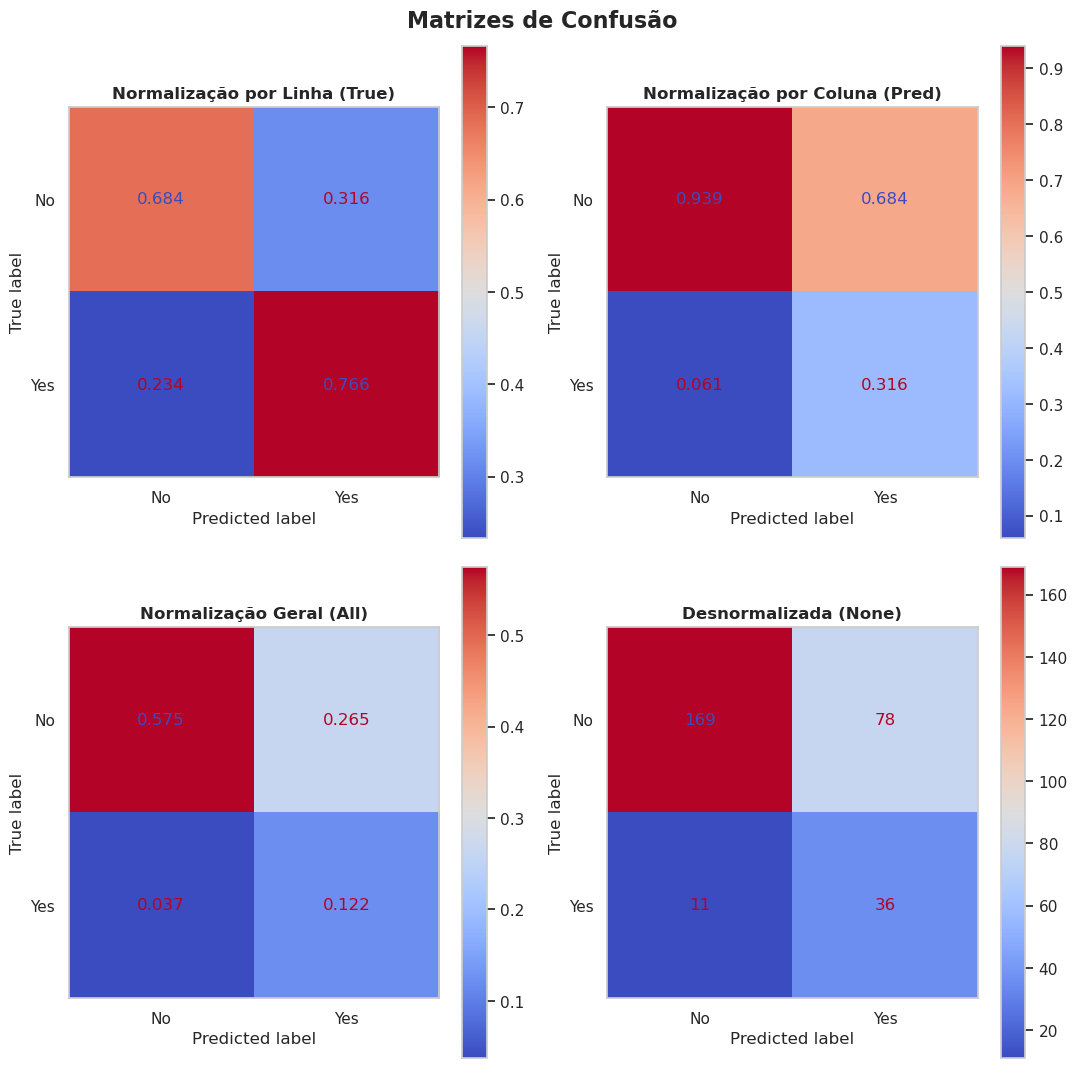

In [33]:
plot_matrizes_confusao(
    modelo=pipelines['LogisticRegression_sampler'],
    X=X_test[lst_ordenada_final],
    y=y_test,
    display_labels=le.classes_,
)

O novo modelo com menos colunas se mostrou tão bom quando o anterior.

Vamos seguir com menos variáveis.

## Salvando o modelo final
Salvando o modelo campeão final, utilizando apenas as colunas importantes.

Vamos retreinar com todo o conjunto de dados para aprender, maximizando o poder de generalização. Temos poucos registros e esse retreino com os melhores hiperparametros se justifica.

In [34]:
lst_ordenada_final.sort()  # ordenando para melhor visualização
print(f'Colunas finais consideradas no modelo:\n{lst_ordenada_final}')

# treinando o modelo final com todos os dados
pipelines['LogisticRegression_sampler'].fit(X[lst_ordenada_final], y)

Colunas finais consideradas no modelo:
['BusinessTravel', 'DailyRate', 'Department-JobRole', 'EnvironmentSatisfaction', 'JobSatisfaction', 'MaritalStatus', 'NumCompaniesWorked', 'OverTime', 'StockOptionLevel', 'TotalWorkingYears', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


,steps,"[('preprocessor', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-2
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
fnc_extended_classification_report(
    y_true=y,
    y_pred=pipelines['LogisticRegression_sampler'].predict(X),
    y_pred_proba=pipelines['LogisticRegression_sampler'].predict_proba(
        X),
    target_names=le.classes_,
)

,Classe,Precisão,Recall,F1-Score,ROC AUC,Precision-Recall,Acurácia,Suporte
0,No,0.942,0.727,0.821,0.821,0.949,0.734,1233
1,Yes,0.351,0.768,0.482,0.821,0.561,0.734,237
2,micro avg,0.734,0.734,0.734,0.816,0.813,0.734,1470
3,macro avg,0.647,0.748,0.652,0.821,0.755,0.734,1470
4,weighted avg,0.847,0.734,0.766,0.821,0.886,0.734,1470


In [36]:
modelo_final_salvo = dump(
    value=pipelines['LogisticRegression_sampler'],
    filename=MODELO_FINAL
)
print(f'\nModelo final salvo em:\n{modelo_final_salvo}')


Modelo final salvo em:
['/dados/hashtag/ciencia_dados/analise-atrito-rh-ibm_classificacao/modelos/modelo_ibm_hr_attrition.joblib']
